Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess



Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [2]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leer la base de datos creada con anterioridad y ver su contenido

In [3]:
df_train = pd.read_hdf('sportBalls_train.h5')
df_test = pd.read_hdf('sportBalls_test.h5')


In [4]:
#df_train.head()

In [5]:
#df_test.head()

In [6]:
#Borrar datos que no requiero.
"""""""""
df_test = df_test[df_test['Etiqueta'] != 'basketball']
df_test = df_test[df_test['Etiqueta'] != 'american_football']
df_test = df_test[df_test['Etiqueta'] != 'hockey_puck']
df_test = df_test[df_test['Etiqueta'] != 'baseball']
df_test = df_test[df_test['Etiqueta'] != 'shuttlecock']
df_test = df_test[df_test['Etiqueta'] != 'volleyball']
df_test = df_test[df_test['Etiqueta'] != 'bowling_ball']

df_train = df_train[df_train['Etiqueta'] != 'basketball']
df_train = df_train[df_train['Etiqueta'] != 'american_football']
df_train = df_train[df_train['Etiqueta'] != 'hockey_puck']
df_train = df_train[df_train['Etiqueta'] != 'baseball']
df_train = df_train[df_train['Etiqueta'] != 'shuttlecock']
df_train = df_train[df_train['Etiqueta'] != 'volleyball']
df_train = df_train[df_train['Etiqueta'] != 'bowling_ball']
"""""""""

"\ndf_test = df_test[df_test['Etiqueta'] != 'basketball']\ndf_test = df_test[df_test['Etiqueta'] != 'american_football']\ndf_test = df_test[df_test['Etiqueta'] != 'hockey_puck']\ndf_test = df_test[df_test['Etiqueta'] != 'baseball']\ndf_test = df_test[df_test['Etiqueta'] != 'shuttlecock']\ndf_test = df_test[df_test['Etiqueta'] != 'volleyball']\ndf_test = df_test[df_test['Etiqueta'] != 'bowling_ball']\n\ndf_train = df_train[df_train['Etiqueta'] != 'basketball']\ndf_train = df_train[df_train['Etiqueta'] != 'american_football']\ndf_train = df_train[df_train['Etiqueta'] != 'hockey_puck']\ndf_train = df_train[df_train['Etiqueta'] != 'baseball']\ndf_train = df_train[df_train['Etiqueta'] != 'shuttlecock']\ndf_train = df_train[df_train['Etiqueta'] != 'volleyball']\ndf_train = df_train[df_train['Etiqueta'] != 'bowling_ball']\n"

Separamos las caracteristicas y etiquetas

In [7]:
# Separar las características y etiquetas
X_train = np.array(df_train['Imagen'])
y_train = df_train['Etiqueta']
X_test = np.array(df_test['Imagen'])
y_test = df_test['Etiqueta']


Verificamos el formato, que sea ideal para la CNN

In [8]:
print(df_test['Imagen'].values[0].shape)
print(df_train['Imagen'].values[0].shape)

(150, 150, 3)
(150, 150, 3)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [9]:
for i in range(X_train.shape[0]):
    X_train[i] = np.array(Image.fromarray(X_train[i]).resize((150,150)))

for i in range(X_test.shape[0]):
    X_test[i] = np.array(Image.fromarray(X_test[i]).resize((150,150)))

Verificamos el formato 

In [10]:
print(X_train[0].shape)
print(X_test[0].shape)

(150, 150, 3)
(150, 150, 3)


Codificamos el formato de las etiquetas para que estén en 0,1,2,3,4,5...

In [11]:
# Codificar las etiquetas
etiquetas_train = y_train.unique()
etiquetas_test = y_test.unique()
y_encoded_train = pd.Categorical(y_train, categories=etiquetas_train).codes
y_encoded_test = pd.Categorical(y_test, categories=etiquetas_test).codes

Verificamos que se haya transformado a un formato minimo y maximo

In [12]:
print(y_encoded_train)
print(y_encoded_test)

[ 0  0  0 ... 14 14 14]
[ 0  0  0 ... 14 14 14]


Hacemos los datos de entrenamiento y los de prueba

In [13]:
# Dividir el dataset en conjuntos de entrenamiento y validación
#X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = X_train, X_test, y_encoded_train, y_encoded_test


Transformar las etiquetas a one_hot. Dependiendo la posición del numero es la etiqueta 

In [14]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

In [15]:
print(y_val_one_hot)
print("Clases originales:", df_train['Etiqueta'].unique())

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Clases originales: ['american_football' 'baseball' 'basketball' 'billiard_ball'
 'bowling_ball' 'cricket_ball' 'football' 'golf_ball' 'hockey_ball'
 'hockey_puck' 'rugby_ball' 'shuttlecock' 'table_tennis_ball'
 'tennis_ball' 'volleyball']


Distribución visual de las etiquetas y su clasificacion

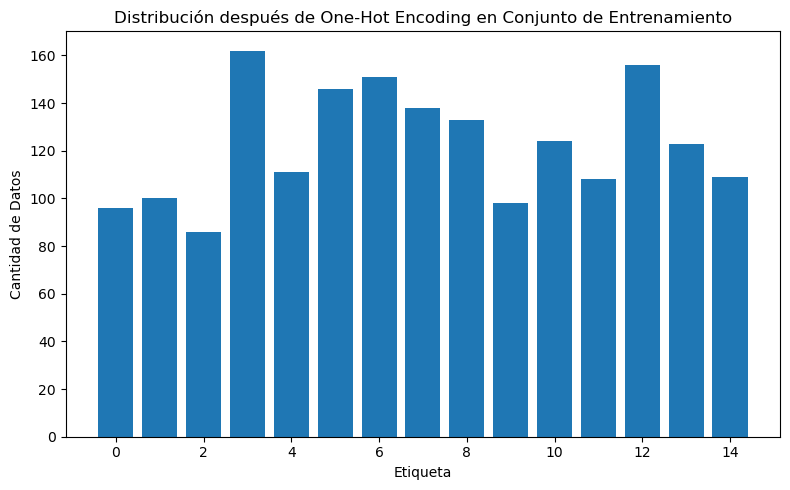

In [16]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

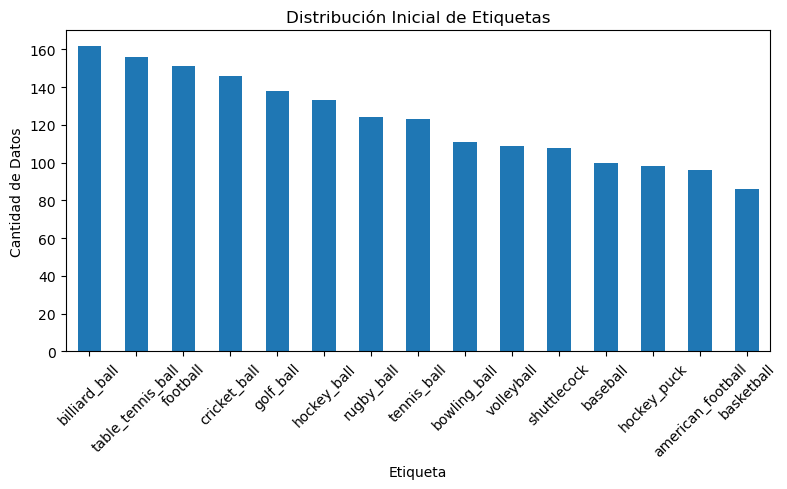

In [17]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df_train['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [18]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [19]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

Generamos infinidad de imagenes (Muchas imagenes. No son infinitas). Definimos los patrones para generar más imagenes y que el modelo no se sobre ajuste

In [20]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Aqui lo aumentamos.

In [21]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=128)


Todo el modelo definido

In [22]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas_train), activation='softmax')  # Capa de salida con activación softmax
])


Compilamos el modelo.

In [23]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Entrenamos el modelo

In [24]:
# Entrenar el modelo con el callback de TensorBoard
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    )


Epoch 1/200
15/15 [==============================] - 16s 762ms/step - loss: 3.2685 - accuracy: 0.0820 - val_loss: 2.6686 - val_accuracy: 0.0961
Epoch 2/200
15/15 [==============================] - 10s 685ms/step - loss: 2.6255 - accuracy: 0.1342 - val_loss: 2.5481 - val_accuracy: 0.1647
Epoch 3/200
15/15 [==============================] - 10s 697ms/step - loss: 2.5576 - accuracy: 0.1532 - val_loss: 2.4926 - val_accuracy: 0.1971
Epoch 4/200
15/15 [==============================] - 11s 722ms/step - loss: 2.4759 - accuracy: 0.1961 - val_loss: 2.4197 - val_accuracy: 0.2166
Epoch 5/200
15/15 [==============================] - 10s 698ms/step - loss: 2.4306 - accuracy: 0.2200 - val_loss: 2.4190 - val_accuracy: 0.2402
Epoch 6/200
15/15 [==============================] - 11s 708ms/step - loss: 2.3262 - accuracy: 0.2466 - val_loss: 2.3240 - val_accuracy: 0.2636
Epoch 7/200
15/15 [==============================] - 11s 765ms/step - loss: 2.2530 - accuracy: 0.2618 - val_loss: 2.2742 - val_accuracy:

Guardamos el modelo

In [25]:
# Guardar el modelo
model.save('modelo_cnn_180Ep_310324.h5')

Obtenemos predicciones del conjunto de validacion

In [26]:
# Evaluar el modelo
with tf.device('/CPU:0'):
    test_loss, test_acc = model.evaluate(X_val, y_val_one_hot)
    print(f'Precisión en el conjunto de pruebas: {test_acc}')

229/229 [==============================] - 44s 190ms/step - loss: 4.3939 - accuracy: 0.4570
Precisión en el conjunto de pruebas: 0.45701420307159424


In [27]:
# Obtener las predicciones del conjunto de validación
with tf.device('/CPU:0'):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

229/229 [==============================] - 30s 132ms/step


Tabla graficamente de la precision y perdida del modelo a partir de las epocas

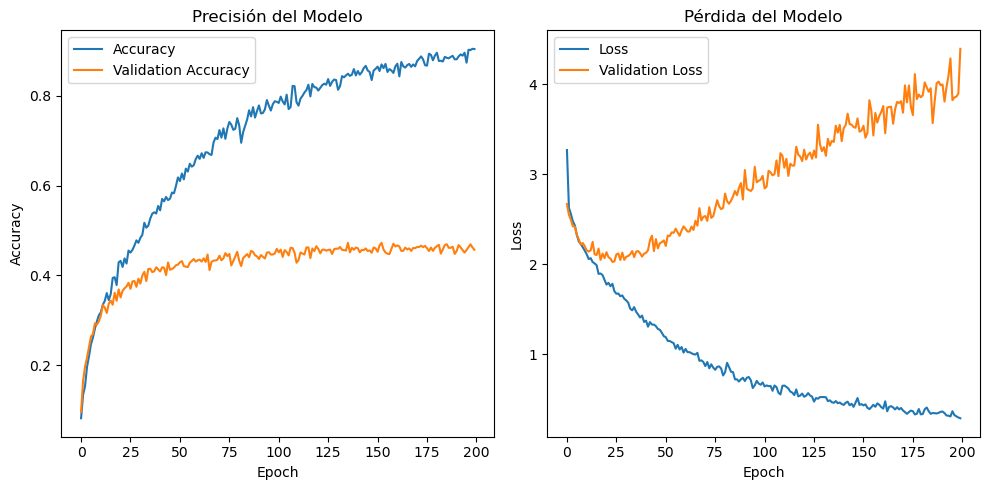

In [28]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

Matriz de confusion

In [29]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

Visualizacion de la matriz de confusion mediante mapa de calor

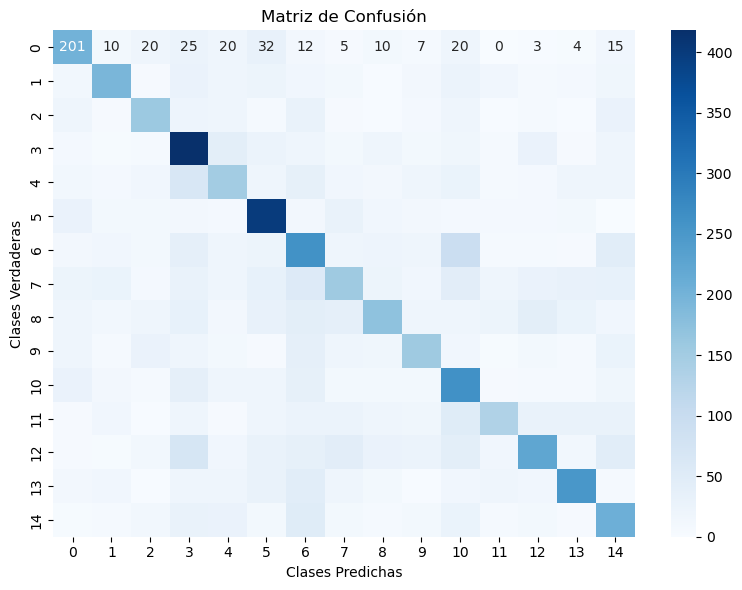

In [30]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()